In [1]:
#This block is for me to run in Google colab
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0,"/content/drive/My Drive/Research/Coherent One Shot Hamiltonian Simulation")

!pip install cirq

Mounted at /content/drive
     |████████████████████████████████| 328 kB 34.6 MB/s 
     |████████████████████████████████| 1.5 MB 39.8 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 409 kB 70.8 MB/s 
     |████████████████████████████████| 47 kB 4.9 MB/s 
     |████████████████████████████████| 1.3 MB 34.2 MB/s 
     |████████████████████████████████| 10.1 MB 43.7 MB/s 
     |████████████████████████████████| 220 kB 56.9 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 4.7 MB/s 
     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 15.7 MB 181 kB/s 
     |████████████████████████████████| 28.5 MB 52 kB/s 
     |████████████████████████████████| 229 kB 75.1 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
    

In [2]:
# Import packages
from qsp_models import *
import tensorflow as tf
import numpy as np

# visualization tools
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import scipy
import IPython

sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = [15, 7]

We will simulate the Hamiltonian
$$ H = H_0 + H_1 $$
where
$$ 
\begin{align}
  H_0 &= \sum_{j = 1}^n h_j \sigma_j^z \\
  H_1 &= \sum_{j = 1}^n ( g_j^x \sigma_j^x \sigma_{j+1}^x + g_j^y \sigma_j^y \sigma_{j+1}^y + g_j^z \sigma_j^z \sigma_{j+1}^z )
\end{align}
$$

For simplicty, we will assume $n=2$ spins. In this case, we can diagonalize $H$, and determine a sufficient $\alpha \geq \|H\|$, given by the expression in the code block below.

In [3]:
#Hamiltonian Properties

h1 = 0
h2 =0
gx = 1
gy = 0
gz = 0

eigenvals = np.array([-gz-(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5, 
                      -gz+(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5,
                      gz-(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5,
                      gz+(gx**2+2*gx*gy+gy**2+h1**2-2*h1*h2+h2**2)**0.5])
alpha = max(np.abs(eigenvals))

Epoch 1/2000
2/2 - 52s - loss: 1.5162 - qsp_5_loss: 0.9410 - qsp_5_1_loss: 0.5752
Epoch 2/2000
2/2 - 0s - loss: 1.2001 - qsp_5_loss: 0.7480 - qsp_5_1_loss: 0.4521
Epoch 3/2000
2/2 - 0s - loss: 0.9156 - qsp_5_loss: 0.5872 - qsp_5_1_loss: 0.3284
Epoch 4/2000
2/2 - 0s - loss: 0.6437 - qsp_5_loss: 0.4298 - qsp_5_1_loss: 0.2139
Epoch 5/2000
2/2 - 0s - loss: 0.4415 - qsp_5_loss: 0.3129 - qsp_5_1_loss: 0.1286
Epoch 6/2000
2/2 - 0s - loss: 0.3102 - qsp_5_loss: 0.2348 - qsp_5_1_loss: 0.0754
Epoch 7/2000
2/2 - 0s - loss: 0.2217 - qsp_5_loss: 0.1759 - qsp_5_1_loss: 0.0458
Epoch 8/2000
2/2 - 0s - loss: 0.1733 - qsp_5_loss: 0.1362 - qsp_5_1_loss: 0.0371
Epoch 9/2000
2/2 - 0s - loss: 0.1492 - qsp_5_loss: 0.1107 - qsp_5_1_loss: 0.0385
Epoch 10/2000
2/2 - 0s - loss: 0.1336 - qsp_5_loss: 0.0901 - qsp_5_1_loss: 0.0435
Epoch 11/2000
2/2 - 0s - loss: 0.1172 - qsp_5_loss: 0.0701 - qsp_5_1_loss: 0.0471
Epoch 12/2000
2/2 - 0s - loss: 0.0986 - qsp_5_loss: 0.0514 - qsp_5_1_loss: 0.0473
Epoch 13/2000
2/2 - 0s -

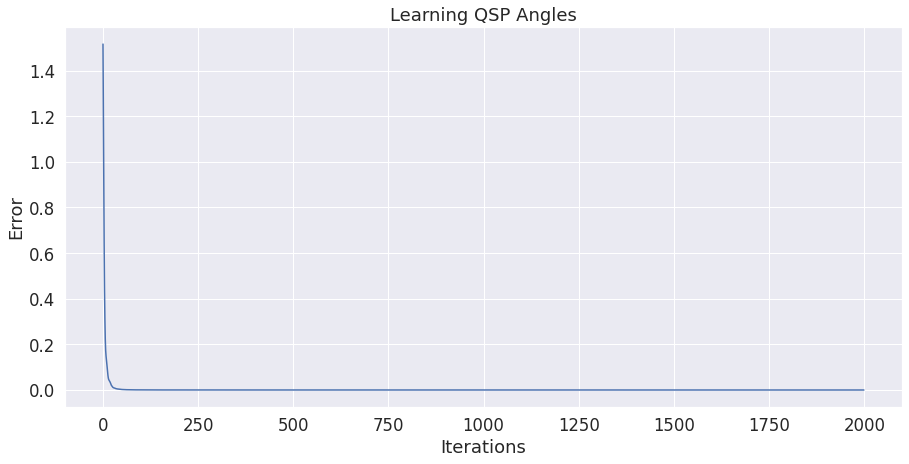

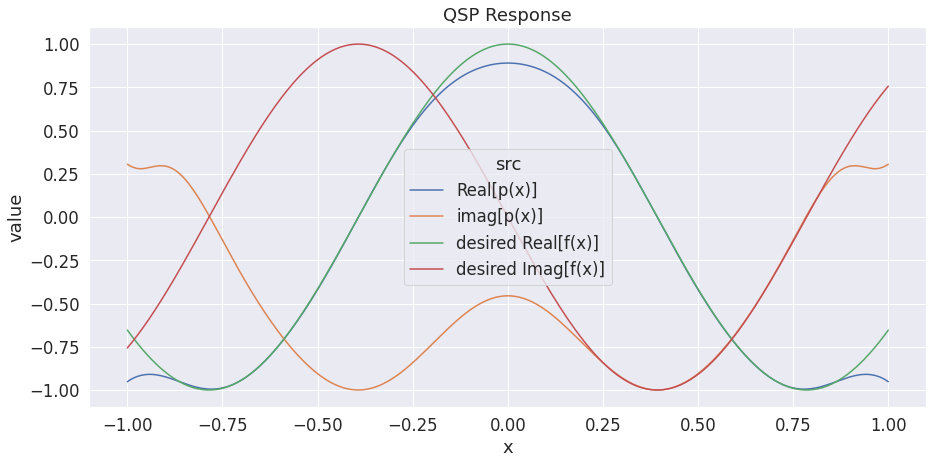

In [24]:
# Simulation setup

t = 1
beta = 1/2
tau = 2*t*alpha/beta

# Polynomial setup
poly_deg = 30
convention = 0    #|0><0| convention
f_real = lambda x: np.cos(tau * x)
f_imag = lambda x: -1*np.sin(tau *x)

# The intput theta training values 
th_in = np.linspace(np.arccos((1+beta)/2), np.arccos((1-beta)/2), 50)
#th_in = np.arange(1/4*np.pi, 3/4*np.pi, np.pi / 50)
th_in = tf.reshape(th_in, (th_in.shape[0], 1))

# We desire p(x) to be f(x)
expected_outputs = [f_real(np.cos(th_in)), f_imag(np.cos(th_in))]

# Train the model
model = construct_qsp_model(poly_deg, convention)
history = model.fit(x=th_in, y=expected_outputs, epochs=2000, verbose=2)
plot_loss(history)
plot_qsp_response(f_real, f_imag, model, convention)

In [25]:
#Output QSP phases
phis = model.trainable_weights[0].numpy()
phis

array([[ 1.3897753 ],
       [ 1.5958844 ],
       [ 1.4482921 ],
       [ 1.3493749 ],
       [-0.35308436],
       [ 1.9236938 ],
       [-0.2698839 ],
       [ 1.0438808 ],
       [ 2.4406798 ],
       [ 1.6584742 ],
       [ 1.6722757 ],
       [ 2.3576384 ],
       [ 2.8218358 ],
       [ 0.89443797],
       [ 0.28406426],
       [ 3.0596986 ],
       [ 0.8707102 ],
       [ 1.7454256 ],
       [ 2.868075  ],
       [ 1.5829316 ],
       [ 1.1437683 ],
       [ 2.2509296 ],
       [ 0.7147786 ],
       [ 2.4913967 ],
       [ 2.0131776 ],
       [ 1.0200236 ],
       [ 0.1916645 ],
       [ 1.0406716 ],
       [ 1.8190795 ],
       [ 1.1996083 ],
       [ 2.5445392 ]], dtype=float32)

In [26]:
# Maximum error of the approximation

qsp_circuit = QSPCircuit(phis)
circuit_px = qsp_circuit.eval_px(th_in)
circuit_response = circuit_px
expected_response = expected_outputs[0][:,0] + 1j*expected_outputs[1][:,0]
deviations = np.absolute(circuit_response - expected_response)

# Worst case and average case errors
epsilon_max = np.max(deviations)
epsilon_mean = np.mean(deviations)

print(epsilon_max)

0.011635129351060916
